In [3]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import seaborn as sns

data_dir = os.path.normpath(os.path.join(os.path.abspath(''), '..', 'data'))
graphs_dir = os.path.normpath(os.path.join(
    os.path.abspath(''), '..', 'graphs'))

default_figsize_x, default_figsize_y = plt.rcParams["figure.figsize"]

sns.reset_defaults()
sns.set_theme(context="paper", font="FiraGO",
              font_scale=1.1, palette="colorblind")
plt.ion()


In [23]:
interesting_genres = [
    "Art & Design",
    "Auto & Vehicles",
    "Beauty",
    "Books & Reference",
    "Business",
    "Communication",
    "Dating",
    "Education",
    "Entertainment",
    "Events",
    "Finance",
    "Food & Drink",
    "Health & Fitness",
    "House & Home",
    "Lifestyle",
    "Maps & Navigation",
    "Medical",
    "Music & Audio",
    "News & Magazines",
    "Parenting",
    "Personalization",
    "Photography",
    "Productivity",
    "Shopping",
    "Social",
    "Sports",
    "Tools",
    "Travel & Local",
    "Video Players & Editors",
    "Weather",
]

type_renamer = lambda t, lang: t.replace('_', ' ') if lang == 'en' else {'data_collected': 'erhobene Daten', 'data_shared': 'weitergegebene Daten'}[t]
type_order = lambda language: ["data collected", "data shared"] if language == 'en' else ["erhobene Daten", "weitergegebene Daten"]

our_data_type_renames = {
    'app_id': 'app ID',
    'os': 'OS version',
    'other_uuids': 'other UUIDs',
    'idfa': 'advertising ID',
    'rooted': 'is device rooted?',
    'ram_usage': 'RAM usage',
    'is_charging': 'is charging?',
    'emulator': 'is device emulator?',
    'local_ips': 'local IPs',
    'hashed_idfa': 'hashed advertising ID',
    'in_foreground': 'in foreground?',
    'bssid': 'BSSID'
}
our_data_type_translations = {
    'app ID': 'App-ID',
    'advertising ID': 'Werbe-ID',
    'OS version': 'Betriebssystem-Version',
    'model': 'Modell',
    'app version': 'App-Version',
    'language': 'Sprache',
    'other UUIDs': 'andere UUIDs',
    'screen size': 'Bildschirmgröße',
    'carrier': 'Netzbetreiber',
    'network connection type': 'Typ der Netzwerkverbindung',
    'country': 'Land',
    'is device rooted?': 'ist das Gerät gerootet?',
    'battery percentage': 'Akkustand',
    'volume': 'Lautstärke',
    'RAM usage': 'RAM-Auslastung',
    'timezone': 'Zeitzone',
    'disk usage': 'Festplattenauslastung',
    'app name': 'App-Name',
    'is charging?': 'Ladestatus',
    'is device emulator?': 'ist das Gerät ein Emulator?',
    'architecture': 'Architektur',
    'user agent': 'User-Agent',
    'local IPs': 'lokale IPs',
    'orientation': 'Bildschirmausrichtung',
    'hashed advertising ID': 'gehashte Werbe-ID',
    'accelerometer': 'Beschleunigungssensor',
    'location': 'Standort',
    'dark mode': 'Dark-Mode',
    'rotation': 'Rotation',
    'signal strength': 'Signalstärke',
    'in foreground?': 'im Vordergrund?',
    'uptime': 'Uptime',
    'viewed page': 'angesehene Seite',
    'roaming': 'Roaming',
}

def our_data_type_renamer(d, language):
    type = (our_data_type_renames[d] if d in our_data_type_renames else d.replace('_', ' '))
    return type if language == 'en' else our_data_type_translations[type]


# Translations taken from: https://support.google.com/googleplay/android-developer/answer/10787469?hl=de
translations = {
    'data_type': {
        "Data type": "Datentyp",
        "Approximate location": "Ungefährer Standort",
        "Precise location": "Genauer Standort",
        "Location": "Standort",
        "Name": "Name",
        "Email address": "E-Mail-Adresse",
        "User IDs": "Nutzer_innen-IDs",
        "Address": "Adresse",
        "Phone number": "Telefonnummer",
        "Race and ethnicity": "Ethnische Zugehörigkeit",
        "Political or religious beliefs": "Politische oder religiöse Überzeugungen",
        "Sexual orientation": "Sexuelle Orientierung",
        "Other info": "Sonstige Daten",
        "User payment info": "Zahlungsinformationen der Nutzer_in",
        "Purchase history": "Bisherige Käufe",
        "Credit score": "Kreditscoring",
        "Other financial info": "Andere Finanzdaten",
        "Health info": "Gesundheitsdaten",
        "Fitness info": "Fitnessdaten",
        "Emails": "E-Mails",
        "SMS or MMS": "SMS oder MMS",
        "Other in-app messages": "Andere In-App-Nachrichten",
        "Photos": "Fotos",
        "Videos": "Videos",
        "Voice or sound recordings": "Sprach- oder Tonaufnahmen",
        "Music files": "Musikdateien",
        "Other audio files": "Sonstige Audiodateien",
        "Files and docs": "Dateien und Dokumente",
        "Calendar events": "Kalendertermine",
        "Contacts": "Kontakte",
        "App interactions": "App-Interaktionen",
        "In-app search history": "Suchverlauf in der App",
        "Installed apps": "Installierte Apps",
        "Other user-generated content": "Andere von Nutzer_innen erstellte Inhalte",
        "Other actions": "Andere Aktionen",
        "Web browsing history": "Browserverlauf",
        "Crash logs": "Absturzprotokolle",
        "Diagnostics": "Diagnosedaten",
        "Other app performance data": "Sonstige App-Leistungsdaten",
        "Device or other IDs": "Geräte- oder andere IDs"
    },
    'purpose': {
        "App functionality": "Funktionen der App",
        "Analytics": "Analyse",
        "Developer communications": "Mitteilungen der Entwickler_in",
        "Advertising or marketing": "Werbung oder Marketing",
        "Fraud prevention, security, and compliance": "Betrugsprävention, Sicherheit und Compliance",
        "Personalization": "Personalisierung",
        "Account management": "Kontoverwaltung"
    },
    'category': {
        "Location": "Standort",
        "Personal info": "Personenbezogene Daten",
        "Financial info": "Finanzdaten",
        "Health and fitness": "Gesundheit und Fitness",
        "Messages": "Nachrichten",
        "Photos and videos": "Fotos und Videos",
        "Audio": "Audiodateien",
        "Files and docs": "Dateien und Dokumente",
        "Calendar": "Kalender",
        "Contacts": "Kontakte",
        "App activity": "App-Aktivitäten",
        "Web browsing": "Surfen im Web",
        "App info and performance": "App-Informationen und -Leistung",
        "Device or other IDs": "Geräte- oder andere IDs"
    },

    'transmission_type': {
        'pseudonymously': 'pseudonymisiert',
        'anonymously': 'anonymisiert',
    },
    'declared': {
        'not declared but observed': 'nicht deklariert, aber beobachtet',
        'declared but not observed': 'deklariert, aber nicht beobachtet',
        'correctly declared': 'korrekt deklariert',
        'correctly not declared': 'korrekt nicht deklariert',
    }
}

def translate(type, string, language):
    if language == 'en':
        return string
    if type in translations and string in translations[type]:
        return translations[type][string]
    raise Exception(f"Could not translate {type} {string}")

def filename(name, language, ext):
    if language == 'en':
        return f"{name}.{ext}"
    return f"{name}_{language}.{ext}"


def thousands_separator_formatter(language):
    return FuncFormatter(lambda x, p: format(int(x), ',')) if language == 'en' else FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))

def declared_renamer(d, language):
    declared = {'wrongly_undeclared': 'not declared but observed', 'correctly_declared': 'correctly declared',
                'unnecessarily_declared': 'declared but not observed', 'correctly_undeclared': 'correctly not declared'}[d]
    return declared if language == 'en' else translations['declared'][declared]

def purpose_renamer(p, language): 
    purpose = {'tracking': 'Analytics', 'ads': 'Advertising or marketing'}[p]
    return purpose if language == 'en' else translations['purpose'][purpose]


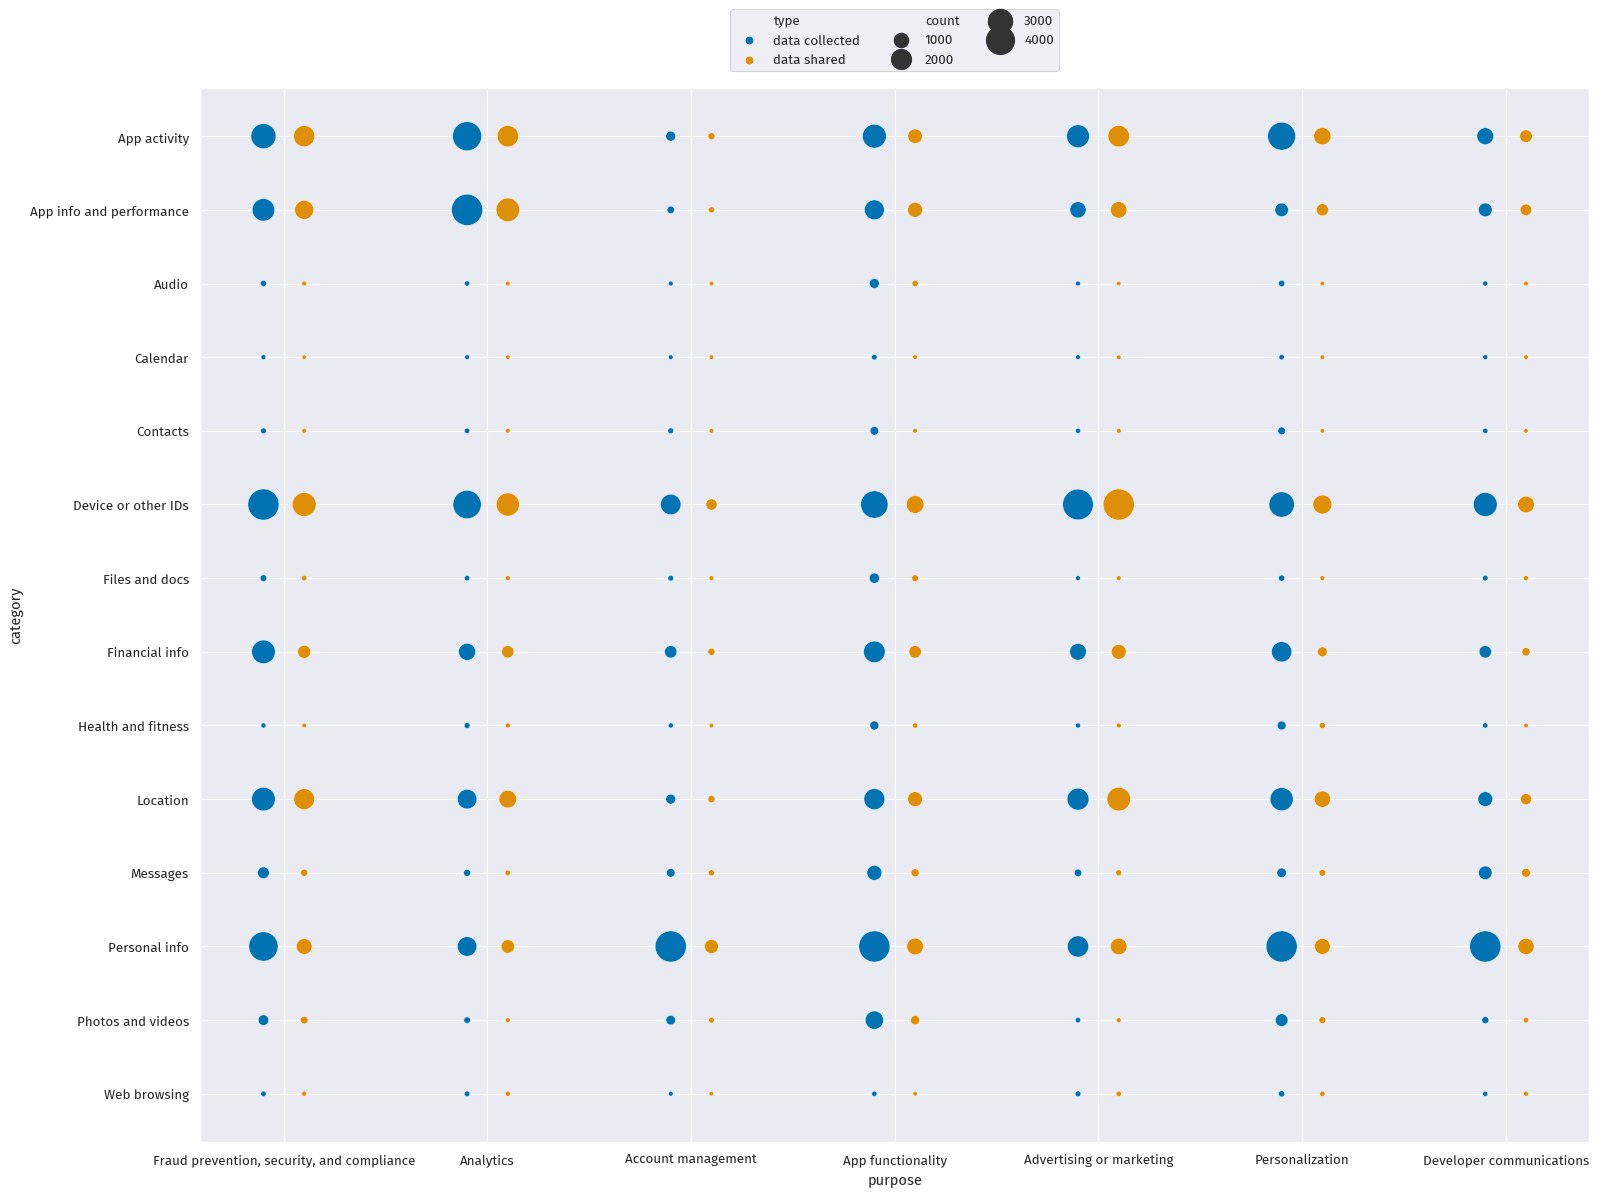

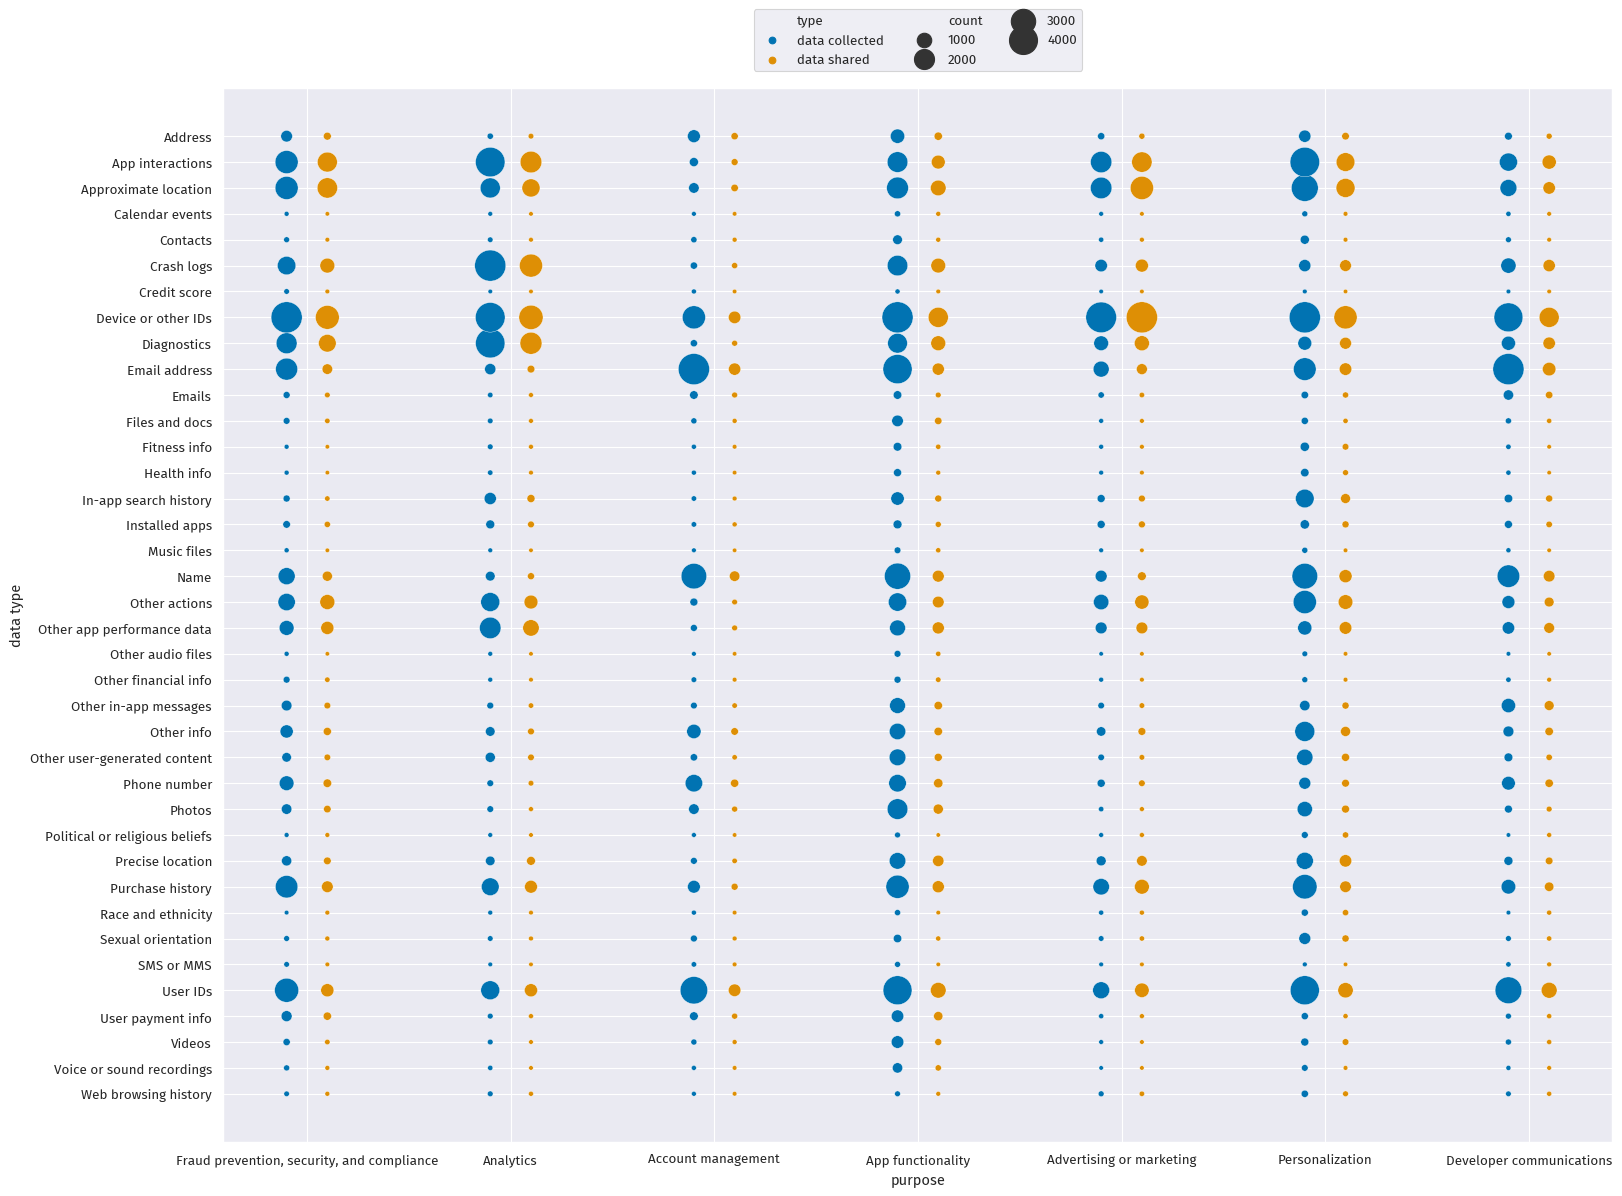

In [113]:
for attribute in ['category', 'data_type']:
    csv = pd.read_csv(os.path.join(
        data_dir, f'declared_{attribute}_purpose_counts.csv'), converters={"type": type_renamer}, on_bad_lines='error')
    ordered_data_types = sorted(csv[attribute].unique(), key=str.lower)
    csv[attribute] = pd.Categorical(
        csv[attribute], categories=ordered_data_types, ordered=True)

    x_labels = csv['purpose'].unique()

    fig, ax = plt.subplots(
        figsize=[2.8*default_figsize_x, 2.85*default_figsize_y])

    for i, label in enumerate(x_labels):
        rows = csv.loc[csv['purpose'] == label]

        x = [i + (-0.1 if platform == 'data collected' else 0.1)
                for platform in rows['type']]
        sns.scatterplot(x=x, y=attribute, size="count", sizes=(10, 500), hue="type", hue_order=['data collected', 'data shared'],
                        data=rows, ax=ax, legend=i == 0)

    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(.5, 1.01), ncol=3)

    ax.set_xticks(range(0, len(x_labels)))
    ax.set_xticklabels(x_labels)

    ax.set_xlabel('purpose')
    ax.set_ylabel(attribute.replace('_', ' '))

    fig.savefig(os.path.join(graphs_dir, f'declaration_matrix_{attribute}.svg'),
                bbox_inches="tight", pad_inches=0)


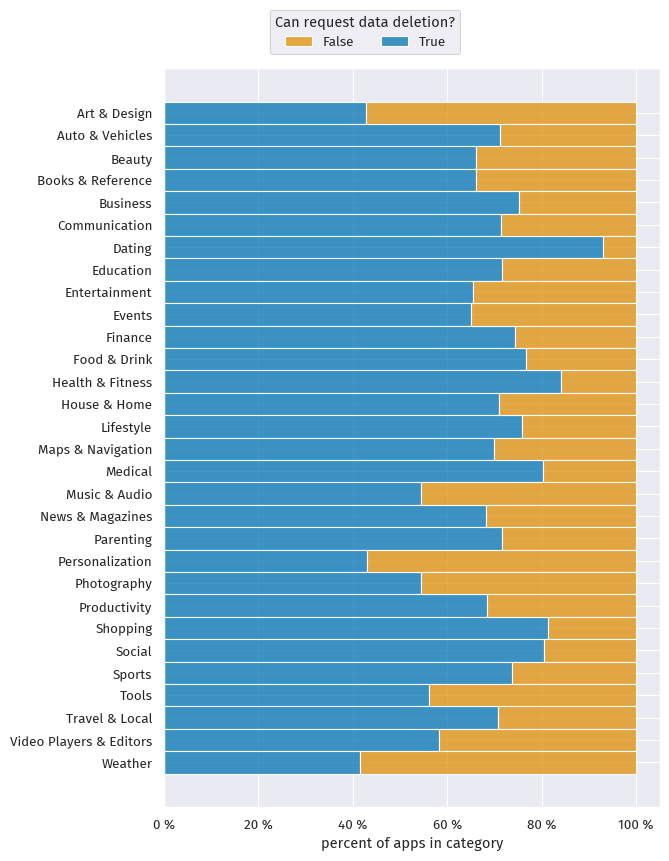

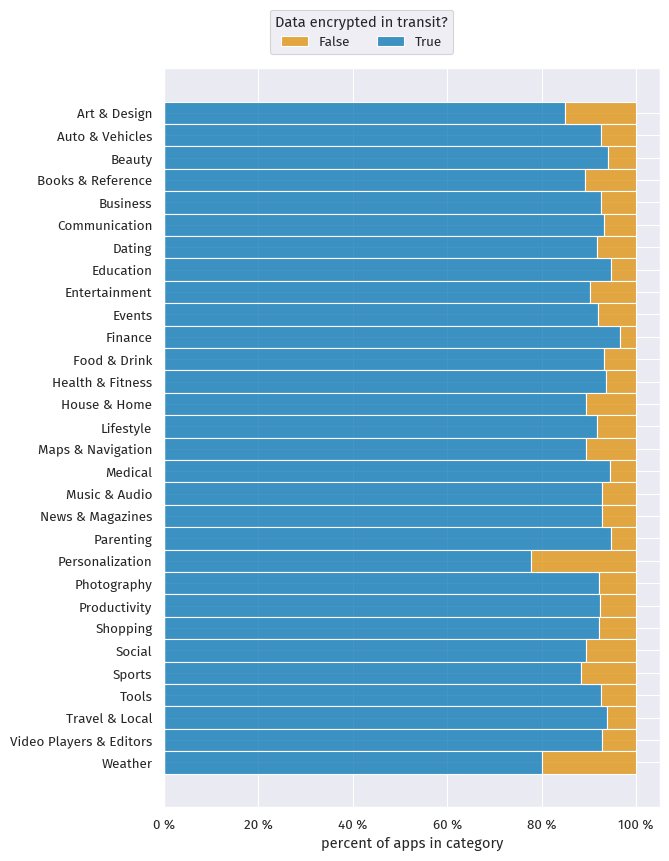

In [114]:
for attribute in ['can_request_data_deletion', 'data_encrypted_in_transit']:
    csv = pd.read_csv(os.path.join(
        data_dir, 'security_practices.csv'), on_bad_lines='error')
    csv = csv.loc[csv['genre'].isin(interesting_genres)]
    # Normalize each bar, https://stackoverflow.com/a/59433700
    csv = csv.groupby('genre')[attribute].value_counts(
        normalize=True).mul(100).rename('percent')
    csv = csv.reset_index()

    fig, ax = plt.subplots(figsize=[default_figsize_x, 2*default_figsize_y])
    # https://www.pythoncharts.com/python/stacked-bar-charts/
    sns.histplot(y="genre", hue=attribute, hue_order=[False, True], palette=[sns.color_palette()[i] for i in [1, 0]],
                    weights="percent", multiple="stack", data=csv, ax=ax)
    
    ax.set_ylabel("")
    ax.set_xlabel("percent of apps in category")
    ax.get_xaxis().set_major_formatter(PercentFormatter(symbol=' %'))
    sns.move_legend(ax, "lower left", title="Can request data deletion?" if attribute == "can_request_data_deletion" else "Data encrypted in transit?", bbox_to_anchor=(0.2, 1.01), ncol=2)

    fig.savefig(os.path.join(graphs_dir, f'{attribute}.svg'),
                bbox_inches="tight", pad_inches=0)


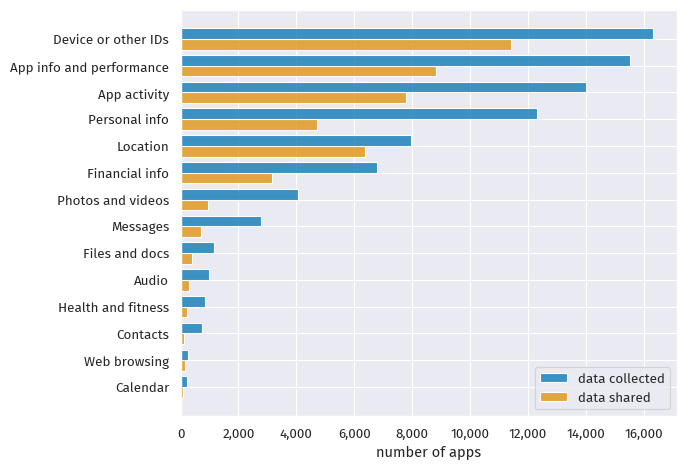

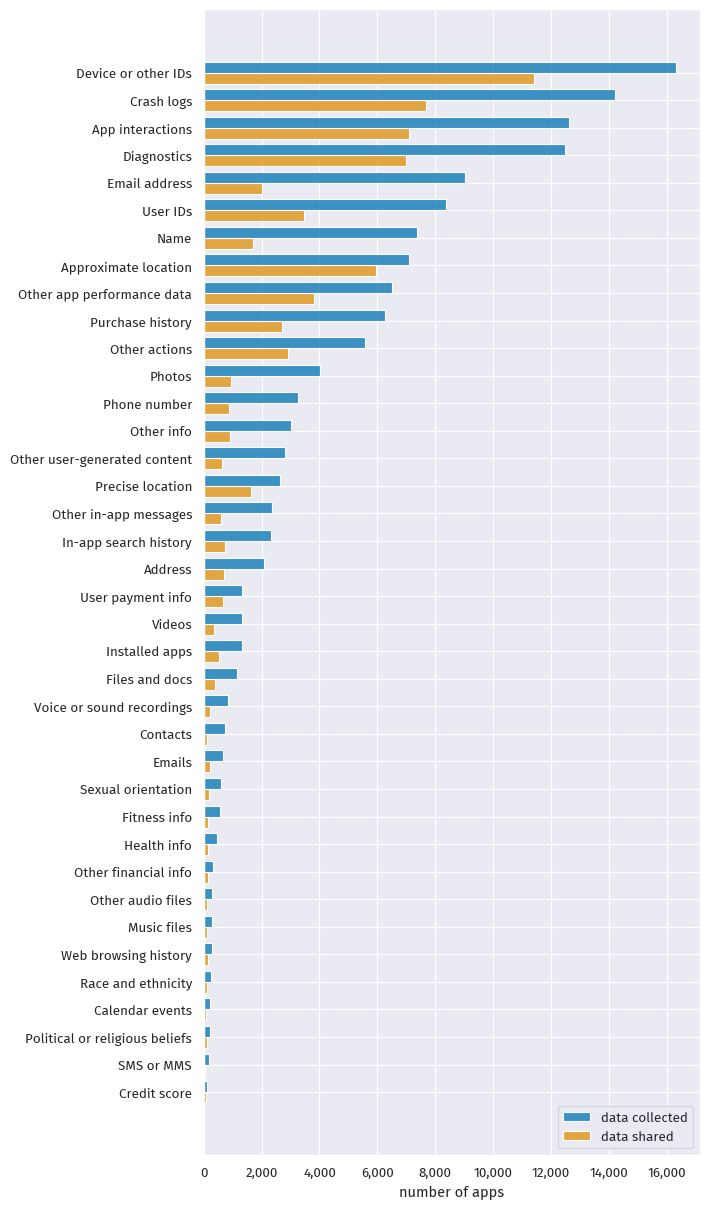

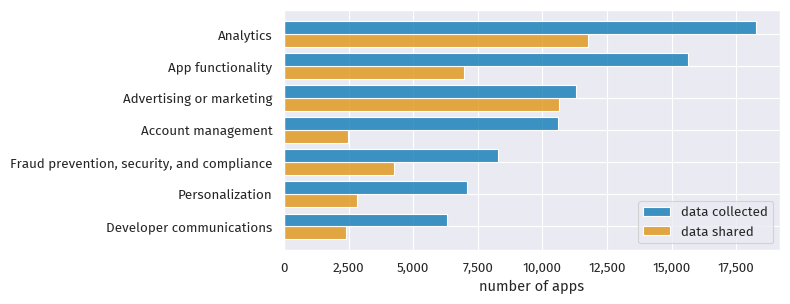

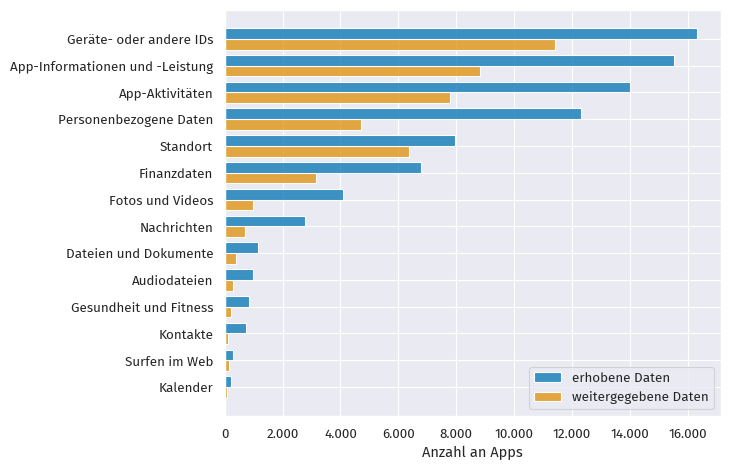

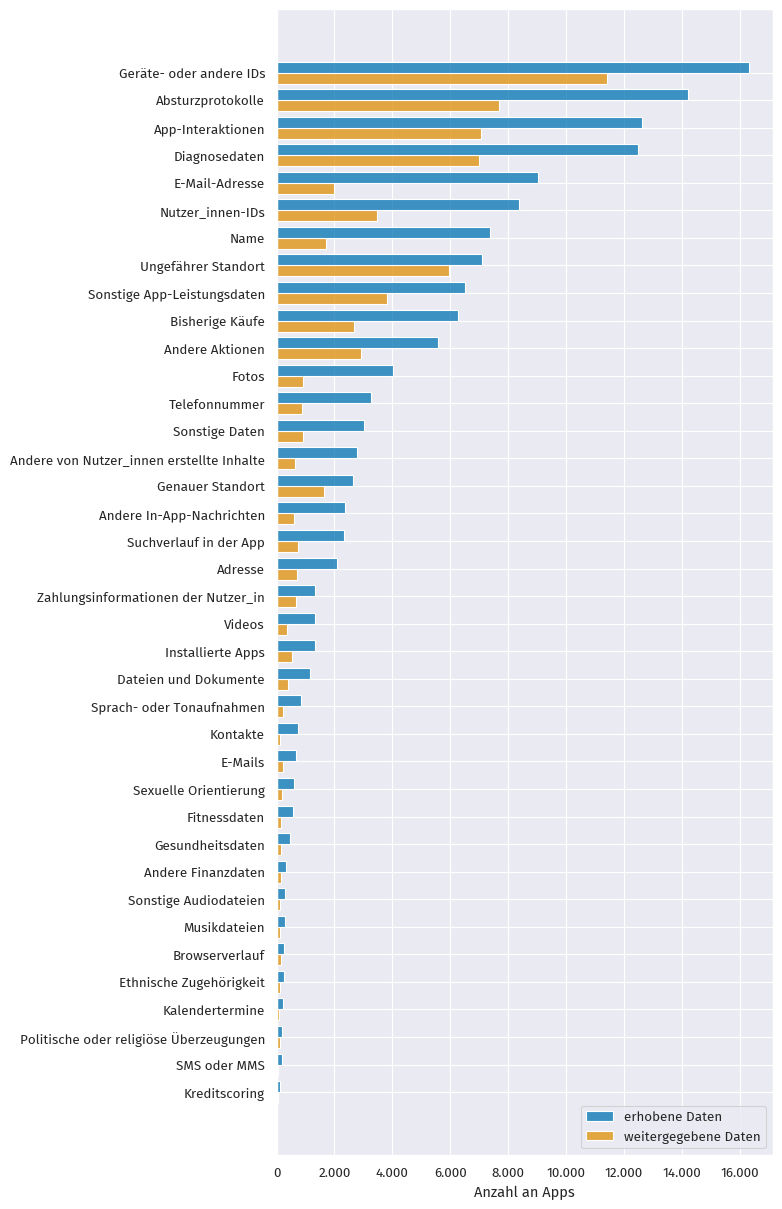

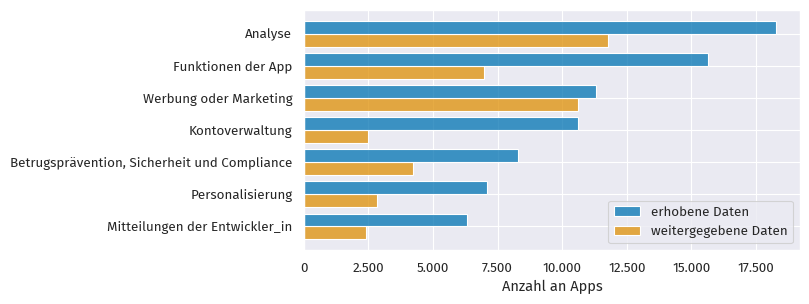

In [150]:
for language in ['en', 'de']:
    params = {
        "category": {"height": 1.1,},
        "data_type": {"height": 3.1},
        "purpose": {"height": 0.65},
    }

    for attribute in ['category', 'data_type', 'purpose']:
        csv = pd.read_csv(os.path.join(
            data_dir, f'declared_{attribute}_counts.csv'), converters={"type": lambda t: type_renamer(t, language), attribute: lambda s: translate(attribute, s, language)}, on_bad_lines='error').sort_values(by=["count"], ascending=False)

        fig, ax = plt.subplots(figsize=[default_figsize_x, params[attribute]["height"]*default_figsize_y])
        # https://www.pythoncharts.com/python/stacked-bar-charts/
        sns.histplot(y=attribute, hue="type", hue_order=type_order(language), palette="colorblind",
                    weights="count", multiple="dodge", shrink=0.8, data=csv, ax=ax)

        ax.get_xaxis().set_major_formatter(thousands_separator_formatter(language))
        ax.set_xlabel("number of apps" if language == 'en' else "Anzahl an Apps")
        ax.set_ylabel("")

        sns.move_legend(ax, "lower right", title="")

        fig.savefig(os.path.join(graphs_dir, filename(f'label_{attribute}_counts', language, 'svg')),
                    bbox_inches="tight", pad_inches=0, transparent=True)


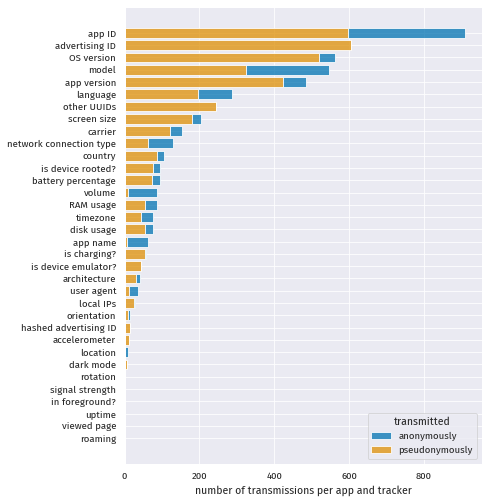

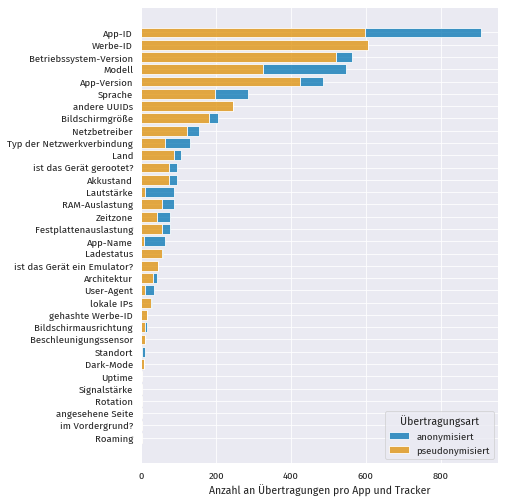

In [24]:
for language in ['en', 'de']:
    csv = pd.read_csv(os.path.join(
        data_dir, f'apps_trackers_data_types.csv'), on_bad_lines='error', converters={'data_type': lambda t: our_data_type_renamer(t, language), 'transmission_type': lambda t: translate('transmission_type', t, language)}).sort_values(by=['data_type'])
    csv['data_type'] = pd.Categorical(
        csv['data_type'], categories=csv['data_type'].value_counts().keys(), ordered=True)

    fig, ax = plt.subplots(figsize=[default_figsize_x, 1.75*default_figsize_y])
    sns.histplot(y="data_type", hue="transmission_type", multiple="stack", hue_order=[
        'anonymously', 'pseudonymously'] if language == 'en' else ['anonymisiert', 'pseudonymisiert'], shrink=0.8, data=csv, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('number of transmissions per app and tracker' if language == 'en' else 'Anzahl an Übertragungen pro App und Tracker')
    sns.move_legend(ax, "lower right", title='transmitted' if language == 'en' else 'Übertragungsart')

    fig.savefig(os.path.join(graphs_dir, filename('traffic_data_types', language, 'svg')),
                bbox_inches="tight", pad_inches=0, transparent=True)


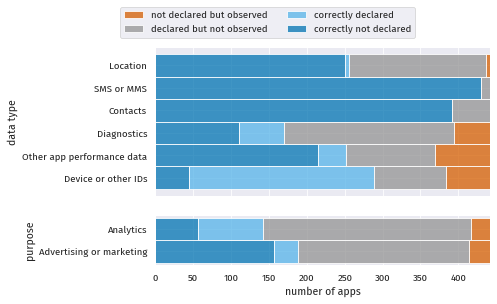

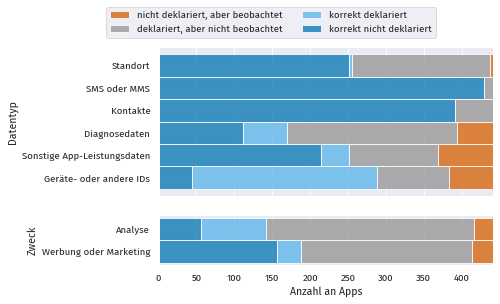

In [21]:
for language in ['en', 'de']:
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True,
                            gridspec_kw={'height_ratios': [6, 2]})

    csv = pd.read_csv(os.path.join(
        data_dir, 'data_type_truthfulness.csv'), on_bad_lines='error', converters={'declared': lambda d: declared_renamer(d, language), 'data_type': lambda s: translate('data_type', s, language)})

    hue_order = ['not declared but observed', 'declared but not observed', 'correctly declared', 'correctly not declared'] if language == 'en' else ['nicht deklariert, aber beobachtet', 'deklariert, aber nicht beobachtet', 'korrekt deklariert', 'korrekt nicht deklariert']
    palette = [sns.color_palette()[i] for i in [3, 7, 9, 0]]

    sns.histplot(y="data_type", hue="declared", hue_order=hue_order, palette=palette,
                multiple="stack", data=csv, ax=axes[0], legend=False)
    axes[0].set_ylabel('data type' if language == 'en' else 'Datentyp')
    axes[0].set_xlim(0, len(csv['app'].unique()))

    csv = pd.read_csv(os.path.join(
        data_dir, 'purpose_truthfulness.csv'), on_bad_lines='error', converters={'declared': lambda d: declared_renamer(d, language), 'purpose': lambda p: purpose_renamer(p, language)})
    sns.histplot(y="purpose", hue="declared", hue_order=hue_order, palette=palette,
                multiple="stack", data=csv, ax=axes[1])
    axes[1].set_ylabel('purpose' if language == 'en' else 'Zweck')
    axes[1].set_xlabel('number of apps' if language == 'en' else 'Anzahl an Apps')
    sns.move_legend(axes[1], "lower center",
                    bbox_to_anchor=(.335, 4.5), ncol=2, title=None)

    fig.savefig(os.path.join(graphs_dir, filename('label_truthfulness', language, 'svg')),
                bbox_inches="tight", pad_inches=0, transparent=True)
